# Capacitated Vehicle Routing Problem
This notebook describes how to use the PyVRP library to solve the Capacitated Vehicle Routing Problem (CVRP). It includes instructions on how to compile the PyVRP library specifically for CVRP and we show how to configure a genetic algorithm to solve a CVRP instance. 

## Compiling PyVRP for CVRP
PyVRP can be directly used to solve CVRP and VRPTW instances. By default, PyVRP compiles all extension modules assuming that the problem to be solved includes time windows. Since CVRP does not include time windows, the default is to use placeholder values for the time windows. These placeholder values are calculated in such a way that the time window constraints are always satisfied - which means that we are actually solving a CVRP instance. However, the time window computations are still part of the compiled extensions, resulting in some computation overhead. 

If performance is critical for your application, then you can build PyVRP yourself using a flag to compile out time window computations. This improves the runtime by 10-20% when compared to the default compilation. To do so, follow the instructions [here](https://pyvrp.readthedocs.io/en/latest/setup/contributing.html#setting-up-a-local-installation) to setup a local installation. Next, run the following command:
```shell
poetry run python build_extensions.py --problem=cvrp --clean
```

This compiles all extension modules without time window computations. We run the code below with the default build.

## Example
Let's now configure our solver to solve a CVRP instnace. First, let's import some necessary components.

In [77]:
from typing import Optional
from pathlib import Path
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import vrplib

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    PenaltyManager,
    Population,
    ProblemData,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.diversity import broken_pairs_distance as bpd
from pyvrp.educate import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    NeighbourhoodParams,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

### Read and plot instance
We will use the `X-n439-k37` instance, which is an instance of the [X benchmark set](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/new-instances) for CVRP. We use the function `pyvrp.read`, which reads the instance file and converts it to a `ProblemData` instance. We pass the argument `round_func='round'` to compute the Euclidean distances rounded to the nearest integral. This is the standard convention for the X benchmark set.

In [61]:
instance = read("data/X-n439-k37.vrp", round_func="round")
instance_bks = vrplib.read_solution("data/X-n439-k37.sol")

Let's plot the instance and see what we have. The function `plotting.plot_demands` will plot the demands of the instance: in this case, all customers have 1 demand. `plotting.plot_oordinates` plots the customer coordinates of the instance.

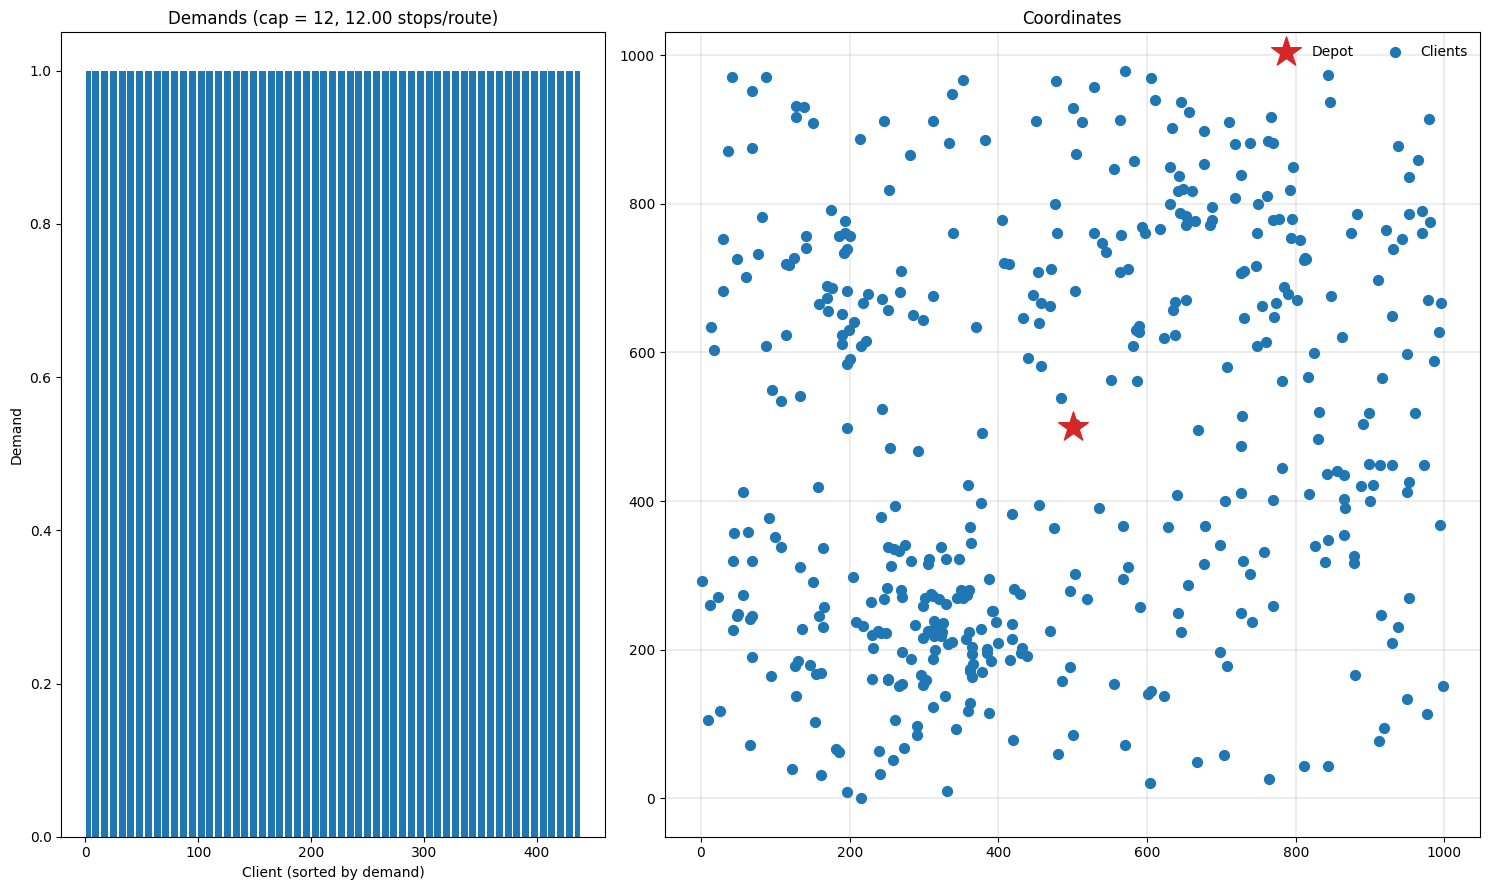

In [62]:
fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2, width_ratios=(2 / 5, 3 / 5))

plotting.plot_demands(instance, ax=fig.add_subplot(gs[:, 0]))
plotting.plot_coordinates(instance, ax=fig.add_subplot(gs[:, 1]))

plt.tight_layout()

Note that we are using the default build, so the instance includes placeholder values for the time windows:

In [74]:
instance.client(1).tw_late

557920

This value is computed by taking the maximum route duration (number of clients $\times$ (maximum distance + maximum service time)). As a result, the time window constraints are always feasible and we are effectively solving the CVRP problem.

### Configure & run Hybrid Genetic Search
Now we will implement the `solve` function that sets up the necessary components of the Hybrid Genetic Search, which is a hybrid between a genetic algorithm and local search. The components include `Population`, `LocalSearch`, and the `PenaltyManager`. Then we will create the `GeneticAlgorithm` object and run it until our desired `StoppingCriterion` is met. 

In [80]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)
    pop = Population(data, pen_manager, rng, bpd)

    nb_params = NeighbourhoodParams(nb_granular=20)
    neighbours = compute_neighbours(data, nb_params)
    ls = LocalSearch(data, pen_manager, rng, neighbours)

    node_ops = [node_op(data, pen_manager) for node_op in NODE_OPERATORS]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops = [route_op(data, pen_manager) for route_op in ROUTE_OPERATORS]

    for op in route_ops:
        ls.add_route_operator(op)

    ga_params = GeneticAlgorithmParams(collect_statistics=True)
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, srex, ga_params)

    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

### Solving the instance

Now let's run the algorithm using our `solve` function and compare the result with the best known solution.

In [81]:
def report_gap(result, bks):
    objective = result.best.cost()
    bks_cost = bks["cost"]
    pct_diff = 100 * (objective - bks_cost) / bks_cost

    print(f"Found a solution with cost: {objective}.")
    print(f"This is {pct_diff:.1f}% worse than the best known", end=" ")
    print(f"solution, which is {bks_cost}.")


result = solve(instance, seed=42, max_runtime=30)
report_gap(result, instance_bks)

Found a solution with cost: 36490.
This is 0.3% worse than the best known solution, which is 36391.


We've managed to find a near-optimal solution in 30 seconds! Let's plot the results.

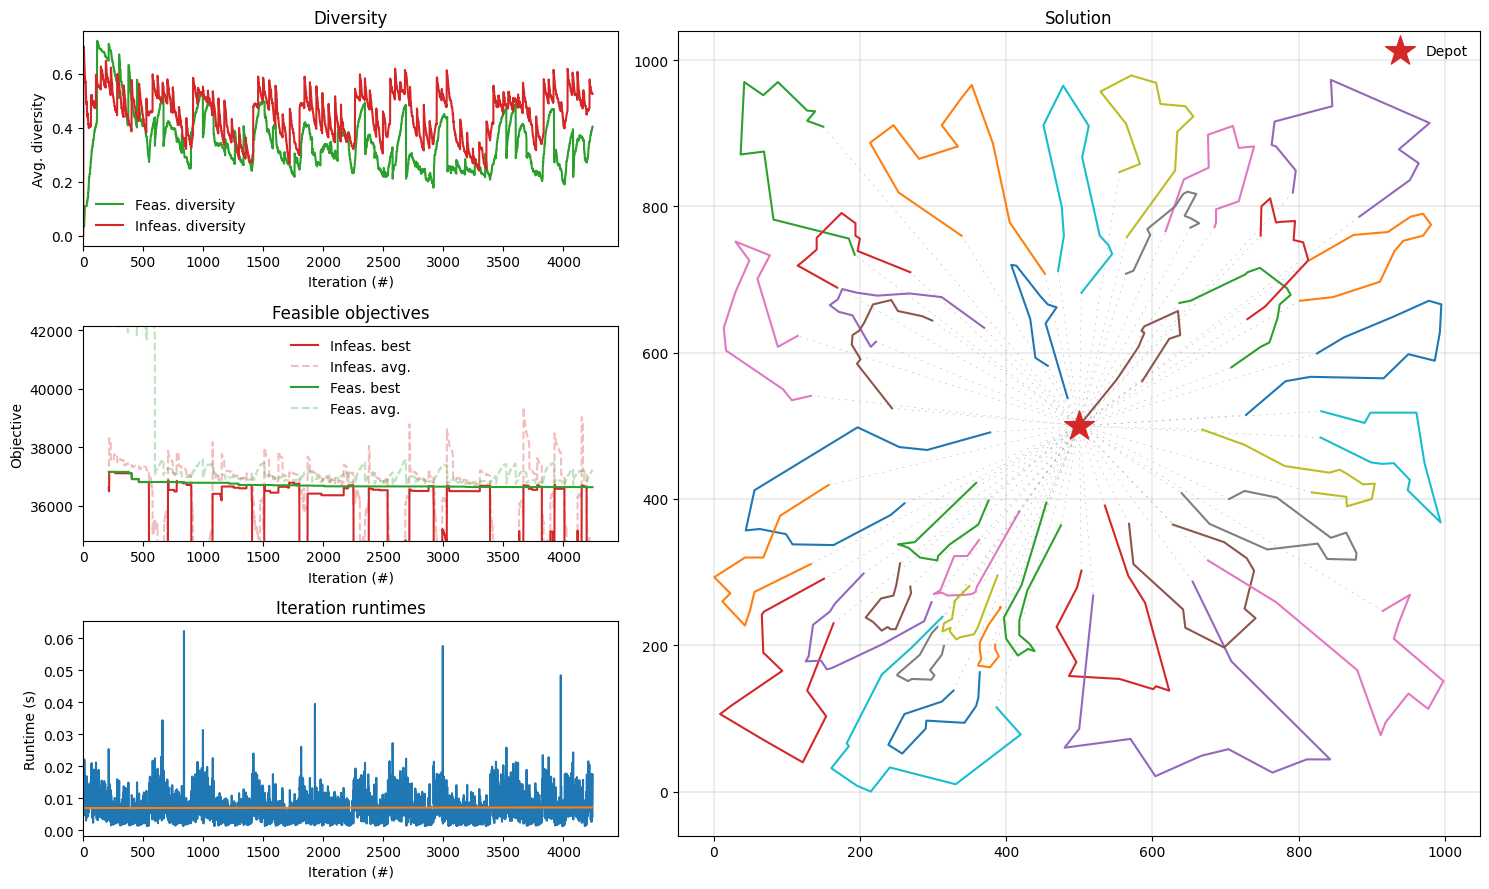

In [79]:
def plot_result(result, instance):
    fig = plt.figure(figsize=(15, 9))
    plotting.plot_result(result, instance, fig)
    fig.tight_layout()


plot_result(result, instance)

## Conclusion
In this notebook, we explained how to compile the PyVRP library without time window computations. This build can be used to solve CVRP faster about 10-20% faster, but we remark that the default PyVRP library can also be used to solve CVRP. We demonstrate how to configure the hybrid genetic search algorithm and we solve an of 439 customers to near-optimality.